In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_tnc, fmin_bfgs
import pandas as pd

plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

**Functions**

In [2]:
def convert1d2d(arr):
    # convert (m, ) to (m, 1), i.e. 1d to 2d 
    return np.reshape(arr, (-1, 1))

def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

def cost(theta, X, y, l=0):
    ''' compute cost J;  since scipy.optimize.fmin expects a single value, the cost function J must return a scalar '''
    
    # prepare variables
    m = len(y)
    theta = convert1d2d(theta)
    temp = sigmoid(X @ theta)
    
    # formula of cost function with regularization term (np.sum() not sum() !)
    regTerm = (l / (2*m)) * np.sum(np.power(theta[1:, :], 2))
    J = - np.sum(y * np.log(temp) + (1 - y) * np.log(1 - temp)) / m + regTerm;
    return J

def grad(theta, X, y, l=0):
    ''' compute gradient; returns array with same dimension as theta '''
    
    # prepare variables
    m = len(y)
    theta = convert1d2d(theta)
    temp = sigmoid(X @ theta)
    
    # gradient vector without correction
    error = temp - y
    grad = (X.T @ error) / m 
    
    # employ regularization if option parameter is passed
    if l != 0:
        for i in range(1, grad.size):
            grad[i, :] += ( l / m * theta[i, :]) # grad and theta have dim (28, 1)
     
    return grad

def predict(theta, X):
    probability = sigmoid(X @ theta)
    return [1 if x >= 0.5 else 0 for x in probability]

def getAccuracy(theta_min, X):
    predictions = predict(theta_min, X)
    correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]
    accuracy = (sum(map(int, correct)) % len(correct))
    return accuracy

def mapFeature(x1, x2, degree=6):
    # returns design matrix with polynomials of features: x1, x2, x1**2, x2**2, x1*x2, x1*x2**2, ...
    # reshaping is needed for decision boundary -> scalar value to array of dim (1, 1)
    m = x1.size
    x1.shape = (m, 1)
    x2.shape = (m, 1)
    X = np.ones(shape=(m, 1))
    for i in range(1, degree + 1):
        for j in range(i + 1):
            r = (x1 ** (i - j)) * (x2 ** j)
            X = np.append(X, r, axis=1)
    return X

def findDecisionBoundary(u, v, theta):
    z = np.zeros(shape=(len(u), len(v)))
    for i in range(len(u)):
        for j in range(len(v)):
            z[i, j] = ( mapFeature( np.array(u[i]), np.array(v[j]) ) @ (np.array(theta)) )
    return z.T

# Logistic Regression I (Standard)

In [3]:
# loading and transforming data
df1 = pd.read_csv("example_2_data_1.txt")
arr = df1.to_numpy()
x1 = convert1d2d(arr[:,0])
x2 = convert1d2d(arr[:,1])
y = convert1d2d(arr[:,2])

In [4]:
# performing logistic regression with library minimizer
m = len(y)
init_theta = np.zeros((3, 1)) # init column vector of parameters 

ones = np.ones((m)) # helping array of shape (m, )
X = np.c_[ones, x1, x2] # concatenate vectors to matrix

sol, n_func_evals, rc = fmin_tnc(cost, init_theta, fprime=grad, args=(X, y))
print("Minimum search took {} iterations and exited with status code {}.\nParameters: {}".format(n_func_evals, rc, sol))

Minimum search took 36 iterations and exited with status code 0.
Parameters: [-25.16131848   0.20623159   0.20147148]


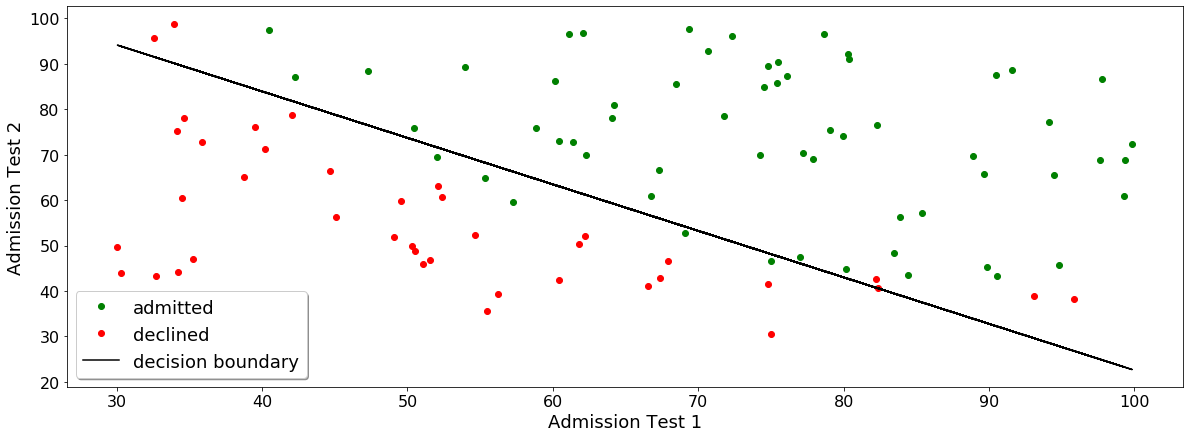

In [5]:
# plotting
pos = np.where(y==1)
neg = np.where(y==0)
boundary = - (sol[0] + x1 * sol[1]) / sol[2]

fig = plt.figure(figsize=(20,7))
plt.plot(x1[pos], x2[pos], color="g", ls="None", marker="o", label="admitted")
plt.plot(x1[neg], x2[neg], color="r", ls="None", marker="o", label="declined")
plt.plot(x1, boundary, color="k", ls="-", markersize="0", label="decision boundary")
plt.xlabel('Admission Test 1')
plt.ylabel('Admission Test 2')
plt.legend(loc="best", fancybox=True, shadow=True)
plt.show()

In [6]:
theta_min = convert1d2d(sol)
accuracy = getAccuracy(theta_min, X)
print('Accuracy: {0}%'.format(accuracy))

Accuracy: 89%


# Logistic Regression II (Regularization)

In [7]:
# loading and transforming data
df2 = pd.read_csv("example_2_data_2.txt")
df2 = df2.reindex(columns=("y", "x1", "x2"))
arr = df2.to_numpy()
y = convert1d2d(arr[:,0])
x1 = convert1d2d(arr[:,1])
x2 = convert1d2d(arr[:,2])

In [8]:
# performing logistic regression with library minimizer
m = len(y)
lambd = 1
init_theta = np.zeros((28, 1))
X = mapFeature(x1, x2, 6)

sol, n_func_evals, rc = fmin_tnc(cost, init_theta, fprime=grad, args=(X, y, lambd))
print("Minimum search took {} iterations and exited with status code {}.\nParameters: {}".format(n_func_evals, rc, sol))

Minimum search took 32 iterations and exited with status code 1.
Parameters: [ 1.27271028  0.62529965  1.18111686 -2.01987401 -0.91743189 -1.4316693
  0.12393227 -0.36553118 -0.35725404 -0.17516292 -1.4581701  -0.05098418
 -0.61558554 -0.27469166 -1.19271298 -0.2421784  -0.20603298 -0.04466178
 -0.27778951 -0.29539514 -0.45645981 -1.04319154  0.02779373 -0.2924487
  0.0155576  -0.32742406 -0.1438915  -0.92467487]


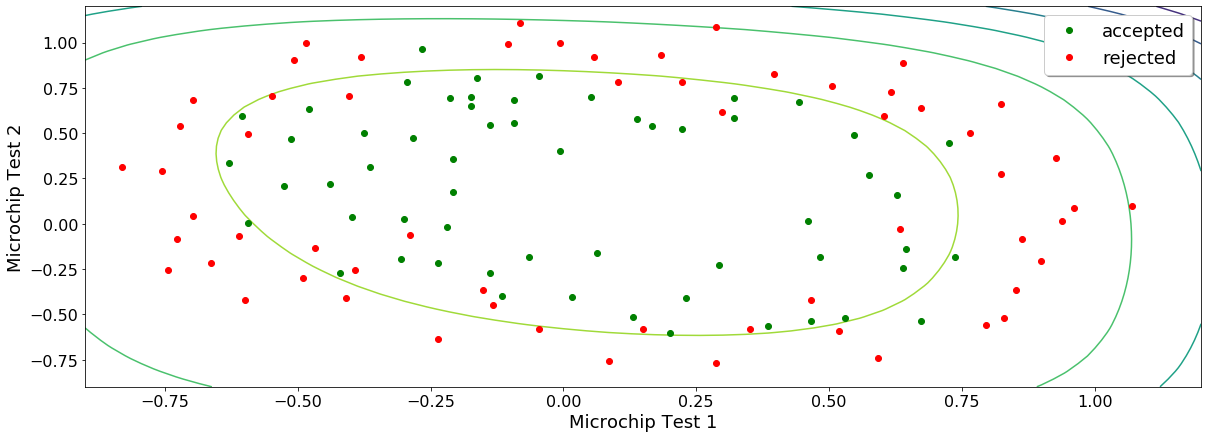

In [9]:
#plotting
pos = np.where(y==1)
neg = np.where(y==0)
xmin, xmax = -0.9, 1.2

u = np.linspace(xmin, xmax, 50)
v = np.linspace(xmin, xmax, 50)
theta_min = convert1d2d(sol)
z = findDecisionBoundary(u, v, theta_min)

fig = plt.figure(figsize=(20,7))
plt.plot(x1[pos], x2[pos], color="g", ls="None", marker="o", label="accepted")
plt.plot(x1[neg], x2[neg], color="r", ls="None", marker="o", label="rejected")
plt.contour(u, v, z)
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.xlim(xmin, xmax)
plt.legend(loc="best", fancybox=True, shadow=True)
plt.show()

In [10]:
theta_min = convert1d2d(sol)
accuracy = getAccuracy(theta_min, X)
print('Accuracy: {}%'.format(accuracy))

Accuracy: 98%


In [11]:
# references:
# https://www.johnwittenauer.net/machine-learning-exercises-in-python-part-3/
# http://aimotion.blogspot.com/2011/11/machine-learning-with-python-logistic.html